#### 라이브러리 로드

In [33]:
# !pip install efficientnet

In [34]:
# !pip install tensorflow_addons

In [35]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import os
efficientdet_dir = '/content/drive/MyDrive/광운대학교 관련/23y 여름 연구참여/efficientdet'
sys.path.append(efficientdet_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import json
from pathlib import Path

from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

import efficientdet

#### 사용가능한 GPU 확인

In [37]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13130459596882228216
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15208677376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4642014300277313320
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


훈련하고자하는 모델 선택 (D-0 ~ D-7)

In [39]:
D = 2 #@param {type: "slider", min: 0, max: 7}

In [40]:
model_config = efficientdet.config.EfficientDetCompudScaling(D=D)
im_size = model_config.input_size

print('Working with images of shape (H, W):', im_size)

Working with images of shape (H, W): (768, 768)


dataset 불러오기

In [41]:
os.chdir('/content/drive/MyDrive/광운대학교 관련/23y 여름 연구참여/efficientdet/examples')

In [42]:
data_path = Path('../dataset')
class_names_file = data_path / 'data_labels.names'
!cat {str(class_names_file)}
class_names_file

crosswalk
LeftTurn
NoLeftTurn
RightTurn
Straight

PosixPath('../dataset/data_labels.names')

`read_class_names`로 class name 매핑

In [43]:
classes, class2idx = efficientdet.utils.io.read_class_names(class_names_file)
class2idx

{'crosswalk': 0, 'LeftTurn': 1, 'NoLeftTurn': 2, 'RightTurn': 3, 'Straight': 4}

`image.jpg`, `image.json` 모두 불러오기

In [44]:
root_data = data_path / 'train_test'
sample_images = list(root_data.glob('*.jpg'))[:3]
sample_annots = [root_data / f'{p.stem}.json' for p in sample_images]

for im_f, annot_f in zip(sample_images, sample_annots):
    print('Image:', str(im_f), '--> Annot:', str(annot_f))

Image: ../dataset/train_test/0405172341_423.5417.jpg --> Annot: ../dataset/train_test/0405172341_423.5417.json
Image: ../dataset/train_test/0405172341_423.7095.jpg --> Annot: ../dataset/train_test/0405172341_423.7095.json
Image: ../dataset/train_test/0405172338_421.4464.jpg --> Annot: ../dataset/train_test/0405172338_421.4464.json


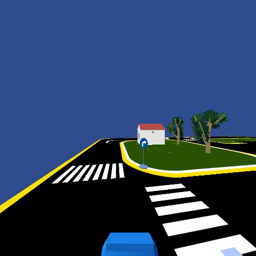

In [45]:
#이미지 확인
Image.open(sample_images[0]).resize((256, 256))

json을 로드 -> `shapes` 속성 : 사각형 pint & class 정보 포함

In [46]:
json.load(sample_annots[0].open())['shapes']

[{'label': 'crosswalk',
  'points': [[128.16831683168317, 304.3564356435644],
   [312.3267326732673, 344.4554455445545]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'crosswalk',
  'points': [[356.38613861386136, 343.96039603960395],
   [639.0, 477.62244915591043]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'RightTurn',
  'points': [[349.45544554455444, 258.81188118811883],
   [370.2475247524753, 279.1089108910891]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [47]:
# 데이터 셋 build
ds = efficientdet.data.labelme.build_dataset(
    annotations_path=root_data,
    images_path=root_data,
    class2idx=class2idx,
    im_input_size=im_size,
    shuffle=True)

image, (labels, bbs) = next(iter(ds))

print('Image shape:', image.shape)
print('Labels shape:', labels.shape)
print('Bounding boxes shape:', bbs.shape)

Image shape: (768, 768, 3)
Labels shape: (5,)
Bounding boxes shape: (5, 4)


The types and shapes are:

| element | dtype | shape |
|--------|--------|-----------
| image | tf.float32 | [HEIGHT, WIDTH, 3] |
| labels | tf.int32 | [N_ELEMS] |
| boxes | tf.float32 | [N_ELEMS, 4] |

Boxes are always formated as (x_min, y_min, x_max, y_max) and using absolute image sizes.

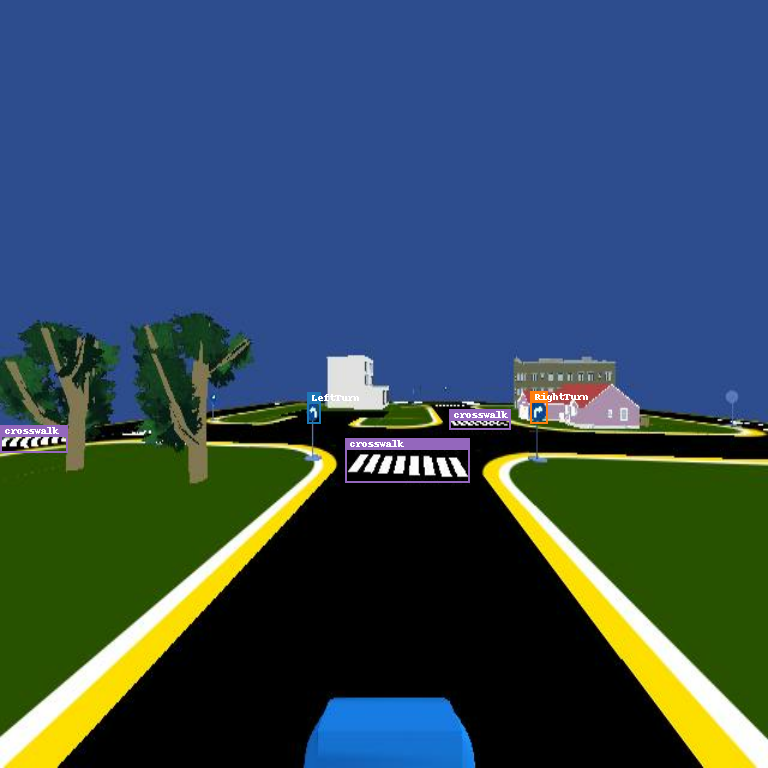

In [48]:
# image 및 label 함께 확인 시각화
image, (labels, bbs) = next(iter(ds))

image_n = efficientdet.data.preprocess.unnormalize_image(image)

labels_name = [classes[l] for l in labels.numpy().tolist()]
colors = efficientdet.visualizer.colors_per_labels(labels_name)

efficientdet.visualizer.draw_boxes(image_n, bbs, labels_name, colors=colors)

train, validation dataset 나누기

In [49]:
ds_len = sum(1 for _ in ds)

train_len = int(ds_len * .9) # 90% of validation data

train_ds = ds.take(train_len) # Take the first instances
valid_ds = ds.skip(train_len) # Skip the first instances, so the sets do not intersect

# Data augmentation on training set
train_ds = (train_ds
            .map(efficientdet.augment.RandomCrop()))

# .map(efficientdet.augment.RandomHorizontalFlip())

In [50]:
batch_size = 4 #@param {type: "slider", min: 2, max: 64}

In [51]:
padded_image_shape = (*im_size, 3)
padded_labels_shape = (None,)
boxes_padded_shape = (None, 4)

train_ds = train_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape,
                                                (padded_labels_shape,
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

valid_ds = valid_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape,
                                                (padded_labels_shape,
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

In [52]:
wrapped_train_ds = efficientdet.wrap_detection_dataset(
        train_ds, im_size=im_size, num_classes=len(class2idx))

wrapped_valid_ds = efficientdet.wrap_detection_dataset(
        valid_ds, im_size=im_size, num_classes=len(class2idx))

## Training

In [53]:
epochs = 100 #@param {type: "slider", min: 2, max: 120}

#@markdown Compute COCO mAP every `valdiate_freq` epochs
valdiate_freq = 10 #@param {type: "slider", min: 1, max: 10}


VOC2007 데이터 셋에서 사전 훈련된 가중치를 사용하여 EfficientDet 사용

5개 parameter 설정
- `D`: EfficientDet 모델 선택
- `num_classes`: 데이터 세트에서 사용 가능한 클래스 `len(class2idx)`.
- `training_mode`: 학습할 때 'True'로 설정합니다.

In [54]:
# model = efficientdet.EfficientDet(D=D,
#                                   num_classes=len(class2idx),
#                                   training_mode=True,
#                                   weights='D0-VOC',
#                                   custom_head_classifier=True)

In [55]:
model = efficientdet.EfficientDet(D=D,
                                  num_classes=len(class2idx),
                                  training_mode=True)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore('/content/drive/MyDrive/광운대학교 관련/23y 여름 연구참여/efficientdet/checkpoints/efficientdet-d2/model')

pre-trained model 불러옴

optimizer, optimizer scheduler 로드

In [75]:
import math

class WarmUpCosineAnnealingScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, learning_rate, warmup_steps, decay_steps, alpha=0.0, m_mul=0.9, t_mul=1.0):
        super(WarmUpCosineAnnealingScheduler, self).__init__()

        self.learning_rate = tf.cast(learning_rate, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.decay_steps = tf.cast(decay_steps, tf.float32)
        self.alpha = tf.cast(alpha, tf.float32)
        self.m_mul = tf.cast(m_mul, tf.float32)
        self.t_mul = tf.cast(t_mul, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        def warmup_lr(): return self.learning_rate * step / tf.maximum(self.warmup_steps, 1.0)
        def base_lr(): return self.learning_rate

        learning_rate = tf.cond(self.warmup_steps > 0, warmup_lr, base_lr)

        # Cosine annealing
        completed_fraction = (step - self.warmup_steps) / tf.maximum(1.0, self.decay_steps - self.warmup_steps)
        cosine_decayed = 0.5 * (1 + tf.math.cos(math.pi * (self.t_mul * completed_fraction)))
        decayed = (1 - self.alpha) * cosine_decayed + self.alpha
        learning_rate *= decayed

        return learning_rate

    def get_config(self):
        return {
            "learning_rate": self.learning_rate,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps,
            "alpha": self.alpha,
            "m_mul": self.m_mul,
            "t_mul": self.t_mul
        }


In [76]:
# CosAnnealing, WarmUp 적용
steps_per_epoch = sum(1 for _ in wrapped_train_ds)
lr = WarmUpCosineAnnealingScheduler(learning_rate=1e-4,
                                    warmup_steps=steps_per_epoch,
                                    decay_steps=steps_per_epoch * (epochs - 1),
                                    alpha=0.1,
                                    m_mul=0.9,
                                    t_mul=1.0)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

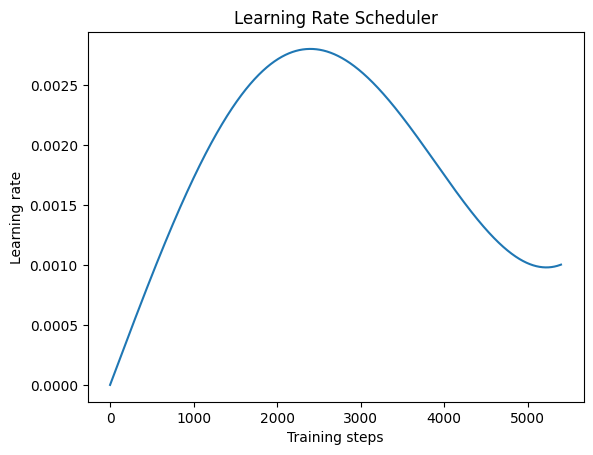

In [77]:
lrs = [lr(o) for o in range(steps_per_epoch * epochs)]

plt.plot(range(len(lrs)), lrs)
plt.xlabel('Training steps')
plt.ylabel('Learning rate')
plt.title('Learning Rate Scheduler')
plt.show();

model complie 및 model trian

In [78]:
clf_loss = efficientdet.losses.EfficientDetFocalLoss()
reg_loss = efficientdet.losses.EfficientDetHuberLoss()

model.compile(loss=[reg_loss, clf_loss],
              optimizer=optimizer, loss_weights=[1., 1.])

model.build([None, *im_size, 3])
model.summary()

Model: "efficient_det_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EfficientNetB2 (Functional)  [(None, None, None, 96),  7768562  
                              (None, None, None, 144)            
                             , (None, None, None, 288            
                             ),                                  
                              (None, None, None, 720)            
                             , (None, None, None, 140            
                             8)]                                 
                                                                 
 bi_fpn_4 (BiFPN)            multiple                  3080707   
                                                                 
 retina_net_classifier_4 (Re  multiple                 51549     
 tinaNetClassifier)                                              
                                                   

`monitor`: 모니터링할 메트릭. 보통 검증 세트에 대한 손실(val_loss) 또는 정확도(val_accuracy) 등을 사용합니다.

`patience`: 지정한 에폭 동안 성능 개선이 없을 경우 학습을 멈춥니다. 예를 들어, patience=10이면 메트릭이 10 에폭 동안 개선되지 않으면 학습이 중단됩니다.

`min_delta`: 개선으로 인정되는 최소 변화량을 나타내며, 이 값보다 작은 절대 변화는 개선으로 간주되지 않습니다.

`mode`: {auto, min, max} 중 하나. min 모드는 관찰하는 양이 감소되는 것을 멈추면 학습이 중단되는 것을 의미하며, max 모드는 관찰하는 양이 증가하는 것을 멈추면 학습이 중단되는 것을 의미합니다. auto 모드는 monitor 인자에서 자동으로 추론합니다.

조기 종료 조건은 본인이 직접 설정하면 되며, 여기서는 검증 데이터의 손실(val_loss)을 기준으로 10 에폭 동안 개선이 없을 경우 학습을 멈추도록 설정하였습니다. 필요에 따라 이 값을 조정하면 됩니다.

In [79]:
# model train
callbacks = [
    efficientdet.callbacks.COCOmAPCallback(valid_ds,
                                           class2idx,
                                           validate_every=valdiate_freq),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=10)
]

with tf.device("/device:GPU:0"):
    history = model.fit(wrapped_train_ds,
                        validation_data=wrapped_valid_ds,
                        epochs=epochs,
                        callbacks=callbacks)


creating index...
index created!
Epoch 1/100
54/54 [==============================] - 200s 514ms/step - loss: 0.0975 - output_1_loss: 0.0238 - output_2_loss: 0.0737 - val_loss: 0.5913 - val_output_1_loss: 0.1190 - val_output_2_loss: 0.4724
Epoch 2/100
54/54 [==============================] - 21s 386ms/step - loss: 0.1355 - output_1_loss: 0.0316 - output_2_loss: 0.1038 - val_loss: 0.9408 - val_output_1_loss: 0.1358 - val_output_2_loss: 0.8049
Epoch 3/100
54/54 [==============================] - 21s 386ms/step - loss: 0.2486 - output_1_loss: 0.0541 - output_2_loss: 0.1945 - val_loss: 0.9874 - val_output_1_loss: 0.2778 - val_output_2_loss: 0.7095
Epoch 4/100
54/54 [==============================] - 21s 383ms/step - loss: 0.2340 - output_1_loss: 0.0545 - output_2_loss: 0.1794 - val_loss: 1.0071 - val_output_1_loss: 0.2405 - val_output_2_loss: 0.7666
Epoch 5/100
54/54 [==============================] - 21s 388ms/step - loss: 0.2400 - output_1_loss: 0.0517 - output_2_loss: 0.1883 - val_loss:

In [80]:
'''

# model train
callbacks = [
    efficientdet.callbacks.COCOmAPCallback(valid_ds,
                                           class2idx,
                                           validate_every=valdiate_freq)
]

with tf.device("/device:GPU:0"):
    history = model.fit(wrapped_train_ds,
            validation_data=wrapped_valid_ds,
            epochs=epochs,
            callbacks=callbacks)


'''

'\n\n# model train\ncallbacks = [\n    efficientdet.callbacks.COCOmAPCallback(valid_ds,\n                                           class2idx,\n                                           validate_every=valdiate_freq)\n]\n\nwith tf.device("/device:GPU:0"):\n    history = model.fit(wrapped_train_ds,\n            validation_data=wrapped_valid_ds,\n            epochs=epochs,\n            callbacks=callbacks)\n\n\n'

`training_mode`를 `False`로 설정하고 `score_threshold`를 변경하면서 조정

In [81]:
model.training_mode = False
model.filter_detections.score_threshold = 0.7 # 0.2이상인 모든 bbox를 표현함

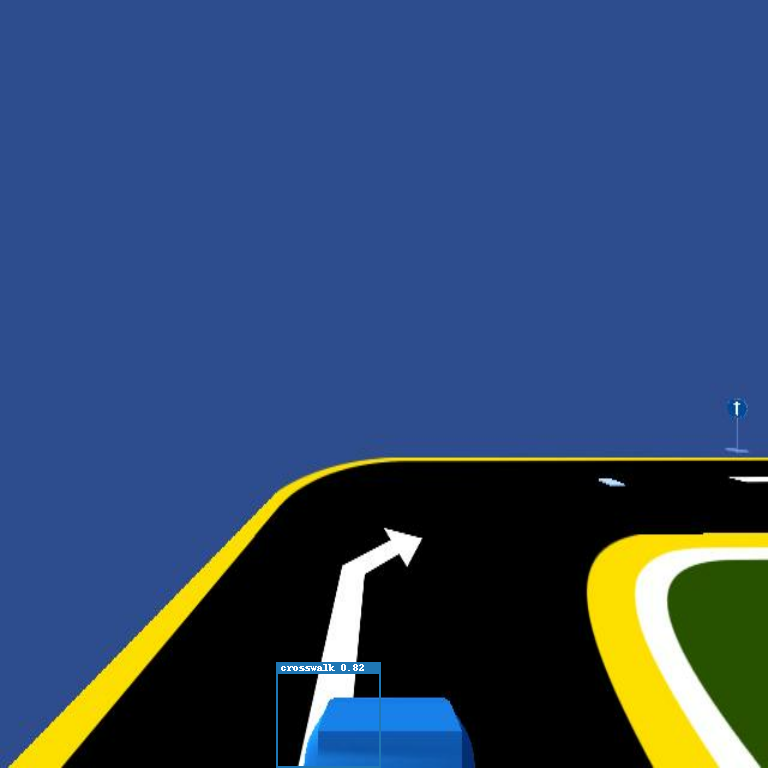

In [83]:
# random image 1장에 대한 예측 시각화

image, _ = next(iter(valid_ds.unbatch().shuffle(20).take(1)))

bbs, labels, scores = model(tf.expand_dims(image, 0), training=False)

image_n = efficientdet.data.preprocess.unnormalize_image(image)

# Covert dataset labels to names
labels_name = [classes[l] for l in labels[0].numpy().tolist()]

# For each different name get a color
colors = efficientdet.visualizer.colors_per_labels(labels_name)

# Get a Pillow image with drew boxes, and automatically plot it
efficientdet.visualizer.draw_boxes(
    image_n, bbs[0], labels_name, scores=scores[0], colors=colors)